In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os



In [18]:
INIT_LR = 1e-3
EPOCHS = 10
BS = 32

In [3]:
data_dir = 'D:/DatasetsCD/train/'
Categories = ["COVID","NORMAL"]



train_data = []
train_labels = []

for category in Categories:
    path = os.path.join(data_dir,category)
    class_num = Categories.index(category)
    for img in(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
            img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
            #img_array = img_array.astype('float32')
            new_array = cv2.resize(img_array,(224 ,224))
            train_data.append([np.array(new_array),class_num])
        except Exception as e:
            pass

In [29]:
#print(len(labels))
print(len(train_data))

3041


In [30]:
train_img=[]
labels = []

for features, label in (train_data):
    train_img.append(features)
    labels.append(label)

train_img = np.array(train_img)/255
labels = np.array(labels)

print(train_img.shape)
print(labels.shape)

(3041, 224, 224, 3)
(3041,)


In [31]:
## split our data set to train and validation

(X_train, X_val, Y_train, Y_val) = train_test_split(train_img, labels,
	test_size=0.2, stratify=labels, random_state=42)

In [32]:
print(X_train.shape)
print(X_val.shape)

(2432, 224, 224, 3)
(609, 224, 224, 3)


In [33]:
## data augmentation initialisation

trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [34]:
## load Vgg-16 model and weights for transfer learning task

baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [35]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)

headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(1, activation="sigmoid")(headModel)


In [36]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [37]:
for layer in baseModel.layers:
	layer.trainable = False

In [38]:
# define adam optimizer and our loss function

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


In [39]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [40]:
## training our model 

print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(X_train, Y_train, batch_size=BS),
	steps_per_epoch=len(X_train) // BS,
	validation_data=(X_val, Y_val),
	validation_steps=len(X_val) // BS,
	epochs=EPOCHS)

[INFO] training head...
  ...
    to  
  ['...']
Train for 76 steps, validate on 609 samples
Epoch 1/10
76/76 [==============================] - 28s 373ms/step - loss: 0.4413 - accuracy: 0.8002 - val_loss: 0.1488 - val_accuracy: 0.9523
Epoch 2/10
76/76 [==============================] - 28s 369ms/step - loss: 0.1532 - accuracy: 0.9544 - val_loss: 0.0714 - val_accuracy: 0.9819
Epoch 3/10
76/76 [==============================] - 27s 355ms/step - loss: 0.0977 - accuracy: 0.9704 - val_loss: 0.0576 - val_accuracy: 0.9836
Epoch 4/10
76/76 [==============================] - 27s 352ms/step - loss: 0.0821 - accuracy: 0.9757 - val_loss: 0.0469 - val_accuracy: 0.9868
Epoch 5/10
76/76 [==============================] - 26s 343ms/step - loss: 0.0710 - accuracy: 0.9778 - val_loss: 0.0571 - val_accuracy: 0.9852
Epoch 6/10
76/76 [==============================] - 26s 349ms/step - loss: 0.0667 - accuracy: 0.9757 - val_loss: 0.0407 - val_accuracy: 0.9852
Epoch 7/10
76/76 [==============================]

Text(0.5, 0, 'epoch')

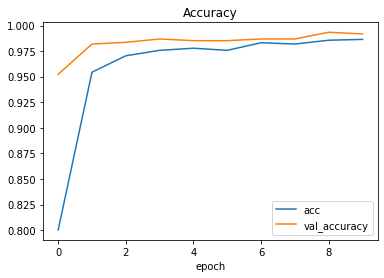

In [41]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.legend(['acc', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

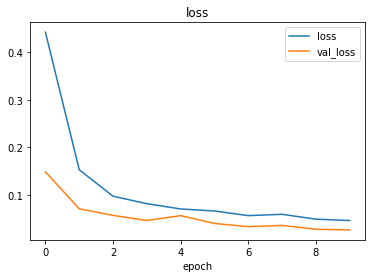

In [42]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')
plt.xlabel('epoch') 

In [43]:
model.save('model2.h5')

In [45]:
#preparing our test data 

data_dir = 'D:/DatasetsCD/Test/'
Categories = ["COVID","NORMAL"]


test_data = []


for category in Categories:
    path = os.path.join(data_dir,category)
    class_num = Categories.index(category)
    for img in(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
            img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
            #img_array = img_array.astype('float32')
            new_array = cv2.resize(img_array,(224 ,224))
            test_data.append([np.array(new_array),class_num])
        except Exception as e:
            pass





In [46]:
len(test_data)

769

In [48]:

test_img=[]
labels = []

for features, label in (test_data):
    test_img.append(features)
    labels.append(label)

X_test = np.array(test_img)/255
Y_test = np.array(labels)

print(X_test.shape)
print(Y_test.shape)


(769, 224, 224, 3)
(769,)


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(X_test)
conf = confusion_matrix(Y_test, np.round(preds))
print(classification_report(Y_test, np.round(preds)))
print(conf)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       474
           1       0.99      0.96      0.97       295

    accuracy                           0.98       769
   macro avg       0.98      0.98      0.98       769
weighted avg       0.98      0.98      0.98       769

[[470   4]
 [ 11 284]]
